# Extraction of Social Groups Using Census Demographic Variables

#### Purpose of this notebook
- 1) Use scikit-learn decomposition algorithms to create social groups across Toronto, Vancouver, Montreal

#### Data Sources
- Census Variables: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E
- Census Geographies: https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm

In [31]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir('C:/Users/Leonardo/OneDrive/Documents/MetroWork/RealEstateData')

In [32]:
# make dataframe with variables of interest
import re
variables = open("CensusData2016/Census/Test2Variables.txt")
var_list = []
for line in variables:
    var_list.append(line)

var_df = pd.DataFrame({'census_variable': var_list})
var_df = var_df.census_variable.str.split(pat = ".", expand=True)[[0,1]]
#var_df = var_df['1'].str.split(pat = "/n", expand=True)[[0,1]]
var_df = var_df[[0,1]]
var_df.columns = ['Member ID: Profile of Dissemination Areas (2247)', 'DIM: Profile of Dissemination Areas (2247)']

In [33]:
# Read Canada Census data by dissemination area
Canada_census_2016 = gpd.read_file('CensusData2016_MA/CanadaWide/CanadaDAs_Census2016_vars.shp')

In [34]:
#function for extracting metropolitan census blocks
def get_metrocensus(canada=None, NAMES=[]): 
    '''filters canadian census layer by metropolitan area, and dissolves all polygons. The result is metropolitan boundaries'''
    #create new col to be used with dissolve
    MAREA = canada[canada.CCSNAME.isin(NAMES)]
    return MAREA

In [35]:
# extract census blocks for all cities
MTMVMOMCMEMM = get_metrocensus(canada=Canada_census_2016,NAMES=['Toronto', 'Vancouver'])
MTMVMOMCMEMM.CMANAME.unique()

array(['Toronto', 'Vancouver'], dtype=object)

# Principal Component Analysis
### Extracting Social Groups from Census Data

### 1: Scale Data and Get rid of Outliers

In [36]:
#prepare dataframe for ML algorithm
df = pd.DataFrame(MTMVMOMCMEMM.iloc[:,23:214])
df = df.replace([np.inf, -np.inf], 0)
#MVDA_Census2016_vars_PCA = MVDA_Census2016_vars_PCA.drop(['index'], axis = 1)
df.head()

,GEO_NAME,6,35,36,37,38,39,40,58,59,...,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247
21630,35201588,6406.7,14.0,70.2,16.5,3.3,42.3,42.0,2.6,525.0,...,0.000000,545.0,70.642202,29.357798,22.018349,7.339450,5.504587,4.587156,1.834862,1.834862
21631,35201589,4751.7,15.9,68.8,14.5,2.2,41.2,41.5,2.8,580.0,...,1.351351,725.0,66.206897,33.793103,24.137931,9.655172,6.206897,6.206897,0.000000,3.448276
21632,35201590,693.0,12.3,71.9,15.8,2.6,43.1,44.9,2.6,505.0,...,0.000000,525.0,62.857143,36.190476,27.619048,8.571429,7.619048,6.666667,0.000000,1.904762
21633,35201591,5299.1,15.3,66.9,16.9,1.6,42.1,42.2,2.6,525.0,...,0.000000,495.0,68.686869,32.323232,25.252525,7.070707,6.060606,7.070707,0.000000,0.000000
21634,35201592,3961.4,12.2,67.1,19.5,4.9,44.2,45.6,2.5,355.0,...,2.150538,455.0,65.934066,32.967033,25.274725,7.692308,5.494505,5.494505,0.000000,2.197802


In [37]:
#split into X data and y blocks
X = df.iloc[:,1:]  # all rows, all the features and no labels
y = df.iloc[:, 0]  # all rows, label (census blocks) only

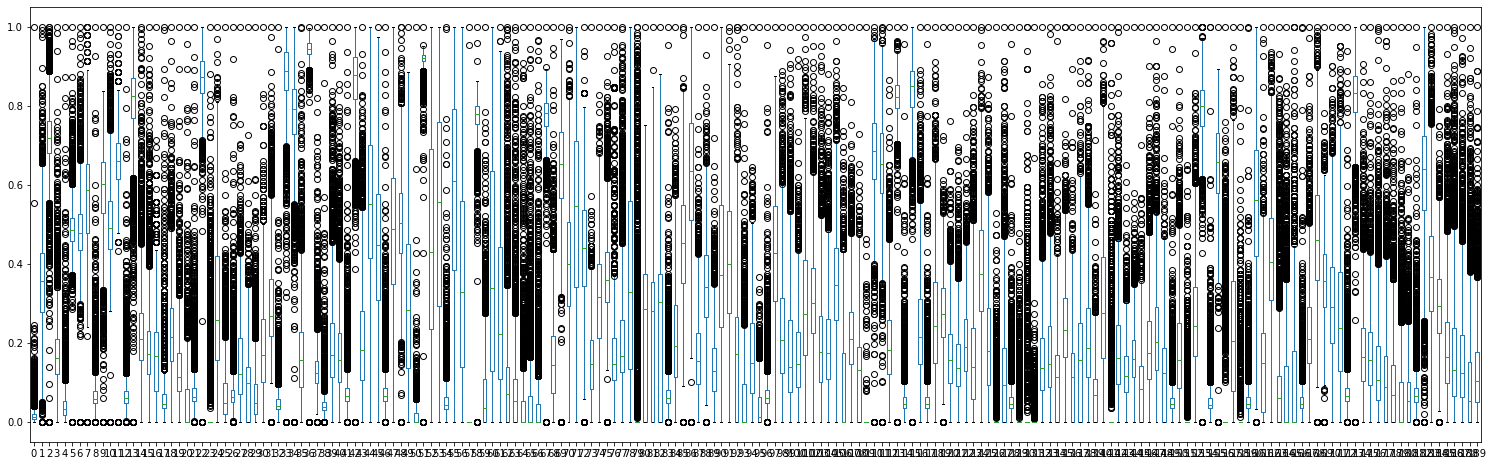

In [38]:
#import libraries, scale the data
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#visualize distribution of variables/outliers
pd.DataFrame(X_scaled).plot.box(figsize=(26,8))

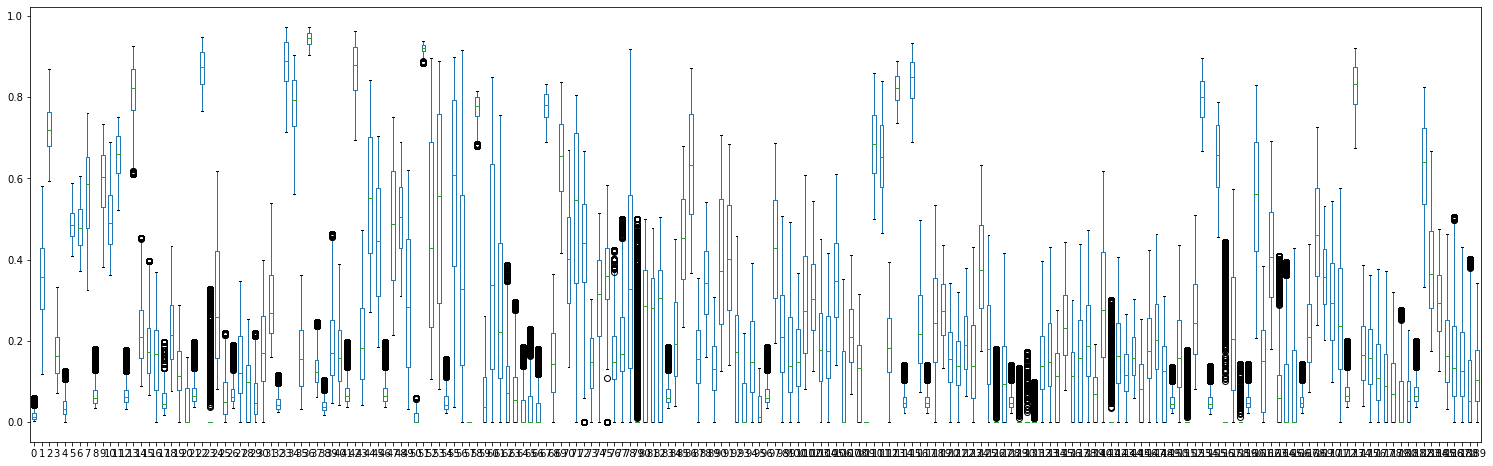

In [39]:
#remove outliers by winsorizing data
X_scaled_wd = mstats.winsorize(X_scaled, inplace = True, axis = 0, limits = [0.05, 0.05])
#visualize data
pd.DataFrame(X_scaled_wd).plot.box(figsize=(26,8))

### 2: Explore PCA as a dimensionality reduction method for our data

Text(0, 0.5, 'cumulative explained variance')

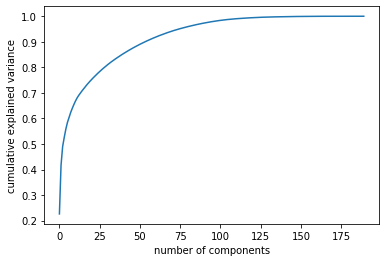

In [41]:
#implement PCA
rdm_st = 1
pca = PCA(random_state=rdm_st).fit(X_scaled_wd)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [42]:
# examine the number of components required to maintain different levels of variance with pca
cumsum = np.cumsum(pca.explained_variance_ratio_)
a = np.argmax(cumsum >= 0.95) + 1
b = np.argmax(cumsum >= 0.90) + 1
c = np.argmax(cumsum >= 0.85) + 1
d = np.argmax(cumsum >= 0.80) + 1
e = np.argmax(cumsum >= 0.75) + 1
f = np.argmax(cumsum >= 0.70) + 1
g = np.argmax(cumsum >= 0.60) + 1
h = np.argmax(cumsum >= 0.55) + 1
print("Number of components needed to maintain 95% explained variance: " + str(a))
print("Number of components needed to maintain 90% explained variance: " + str(b))
print("Number of components needed to maintain 85% explained variance: " + str(c))
print("Number of components needed to maintain 80% explained variance: " + str(d))
print("Number of components needed to maintain 75% explained variance: " + str(e))
print("Number of components needed to maintain 70% explained variance: " + str(f))
print("Number of components needed to maintain 60% explained variance: " + str(g))
print("Number of components needed to maintain 55% explained variance: " + str(h))

Number of components needed to maintain 95% explained variance: 76
Number of components needed to maintain 90% explained variance: 55
Number of components needed to maintain 85% explained variance: 40
Number of components needed to maintain 80% explained variance: 29
Number of components needed to maintain 75% explained variance: 21
Number of components needed to maintain 70% explained variance: 15
Number of components needed to maintain 60% explained variance: 7
Number of components needed to maintain 55% explained variance: 5


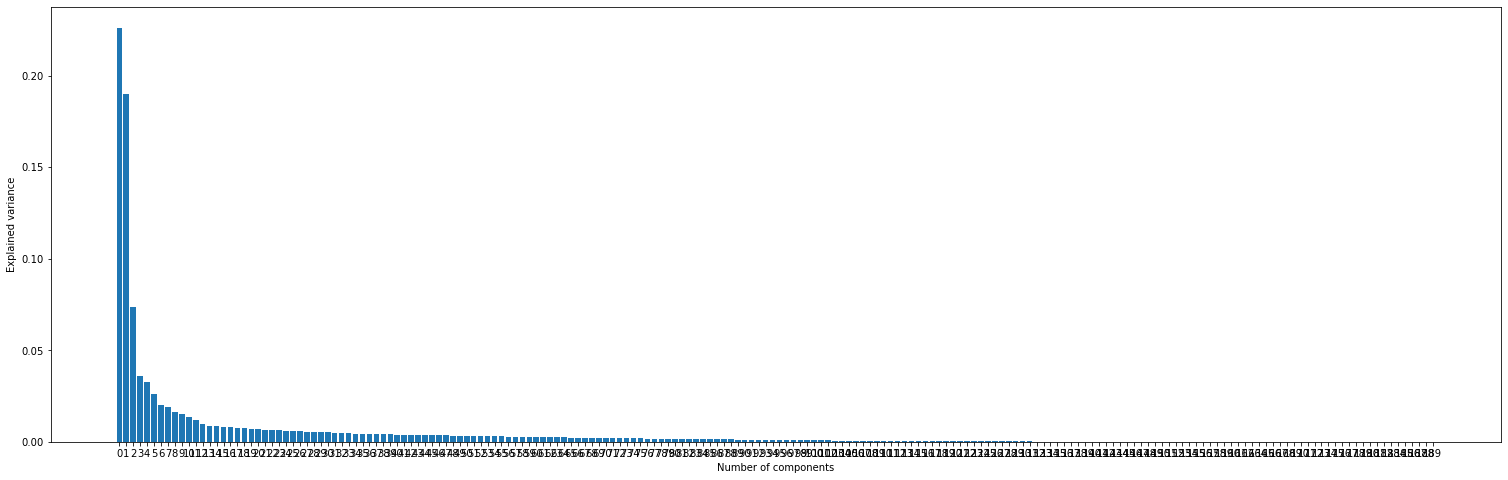

In [43]:
features = range(pca.n_components_)
plt.figure(figsize=(26,8))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xticks(features);

### 2.1: Testing the performance of PCA vs. NMF for dimensionality reduction

In [46]:
#https://stackoverflow.com/questions/48148689/how-to-compare-predictive-power-of-pca-and-nmf
from sklearn import decomposition, model_selection, preprocessing, metrics
# split the dataset, to measure overfitting
X_train, X_test = model_selection.train_test_split(X_scaled_wd, test_size=0.5, random_state=1)
# train the both decomposers
pca = decomposition.PCA(n_components=4).fit(X_train)
nmf = decomposition.NMF(n_components=4).fit(X_train)
print(sum(pca.explained_variance_ratio_))

0.5255038125152355


In [48]:
def get_score(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

print('train set performance')
print(get_score(pca, X_train))
print(get_score(nmf, X_train))

print('test set performance')
print(get_score(pca, X_test))
print(get_score(nmf, X_test))
#Choice is PCA

train set performance
0.38285719067586205
0.31523897555901853
test set performance
0.38177292310001054
0.3127970771151373


### 3: Fit PCA and NMF to data and transform original data

In [49]:
#fit 5 component PCA and NMF to data: create PCA for variables ('components') and for geometries ('X_transformed')
pca = PCA(n_components=4)
nmf = NMF(n_components=4)
components_PCA = pca.fit(X_scaled_wd).components_
components_NMF = nmf.fit(X_scaled_wd).components_
X_transformed_PCA = pca.fit_transform(X_scaled_wd)
X_transformed_NMF = nmf.fit_transform(X_scaled_wd)

In [50]:
#create dataframe for components and geometries (GEO_NAME)
DAUID_PCA = pd.DataFrame(X_transformed_PCA, y).reset_index()
DAUID_NMF = pd.DataFrame(X_transformed_NMF, y).reset_index()
#DAUID_PCA_BC['GEO_NAME'] = MVDA_Census2016_vars_PCA['GEO_NAME']
# print(DAUID_PCA.info())
# print(DAUID_NMF.info())

In [51]:
#adjust dataframes for merging
MTMVMOMCMEMM.columns = MTMVMOMCMEMM.columns.astype(str)
DAUID_PCA.columns = DAUID_PCA.columns.astype(str)
DAUID_NMF.columns = DAUID_NMF.columns.astype(str)
MTMVMOMCMEMM['DAUID'] = MTMVMOMCMEMM['DAUID'].astype('int64')
#merge layer to be exported
PCA_Census2016_5PCs = pd.merge(MTMVMOMCMEMM, DAUID_PCA, left_on='DAUID', right_on='GEO_NAME')
PCA_Census2016_5PCs = PCA_Census2016_5PCs.set_index('DAUID')
NMF_Census2016_5PCs = pd.merge(MTMVMOMCMEMM, DAUID_NMF, left_on='DAUID', right_on='GEO_NAME')
NMF_Census2016_5PCs = NMF_Census2016_5PCs.set_index('DAUID')
#BCDA_Census2016_5PCs.to_file('CensusData2016_MA/MTMVMOMCMEMM_DA_Census2016_5PC.shp')

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [52]:
PCA_Census2016_5PCs.to_file('CensusData2016_MA/PCA/CTCV_DA_Census2016_5PC.shp')

### 4: Visualize components for PCA and NMF

In [53]:
#create dataframe for components and variables transposed
columns = X.columns
PCA_CPs = pd.DataFrame(components_PCA, columns=columns).T.reset_index()
NMF_CPs = pd.DataFrame(components_NMF, columns=columns).T.reset_index()

In [54]:
#add original variable names to the PCA components dataframe
PCA_CPs = pd.merge(PCA_CPs,var_df, left_on='index', right_on='Member ID: Profile of Dissemination Areas (2247)')
PCA_CPs = PCA_CPs.drop(['Member ID: Profile of Dissemination Areas (2247)'], axis=1)
PCA_CPs = PCA_CPs.set_index('DIM: Profile of Dissemination Areas (2247)')
#add original variable names to the NMF components dataframe
NMF_CPs = pd.merge(NMF_CPs,var_df, left_on='index', right_on='Member ID: Profile of Dissemination Areas (2247)')
NMF_CPs = NMF_CPs.drop(['Member ID: Profile of Dissemination Areas (2247)'], axis=1)
NMF_CPs = NMF_CPs.set_index('DIM: Profile of Dissemination Areas (2247)')

In [ ]:
# #plot heatmap of variables and components --> how were the components create?
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(20,50))
# sns.heatmap(test_PCA_BC.drop(['index'], axis=1), annot=False, cmap  = 'RdBu');
# #sns.clustermap(test_PCA_BC.drop(['index'], axis=1), annot=False, figsize=(20,50), cmap  = 'viridis');

### How were the PCA components created?

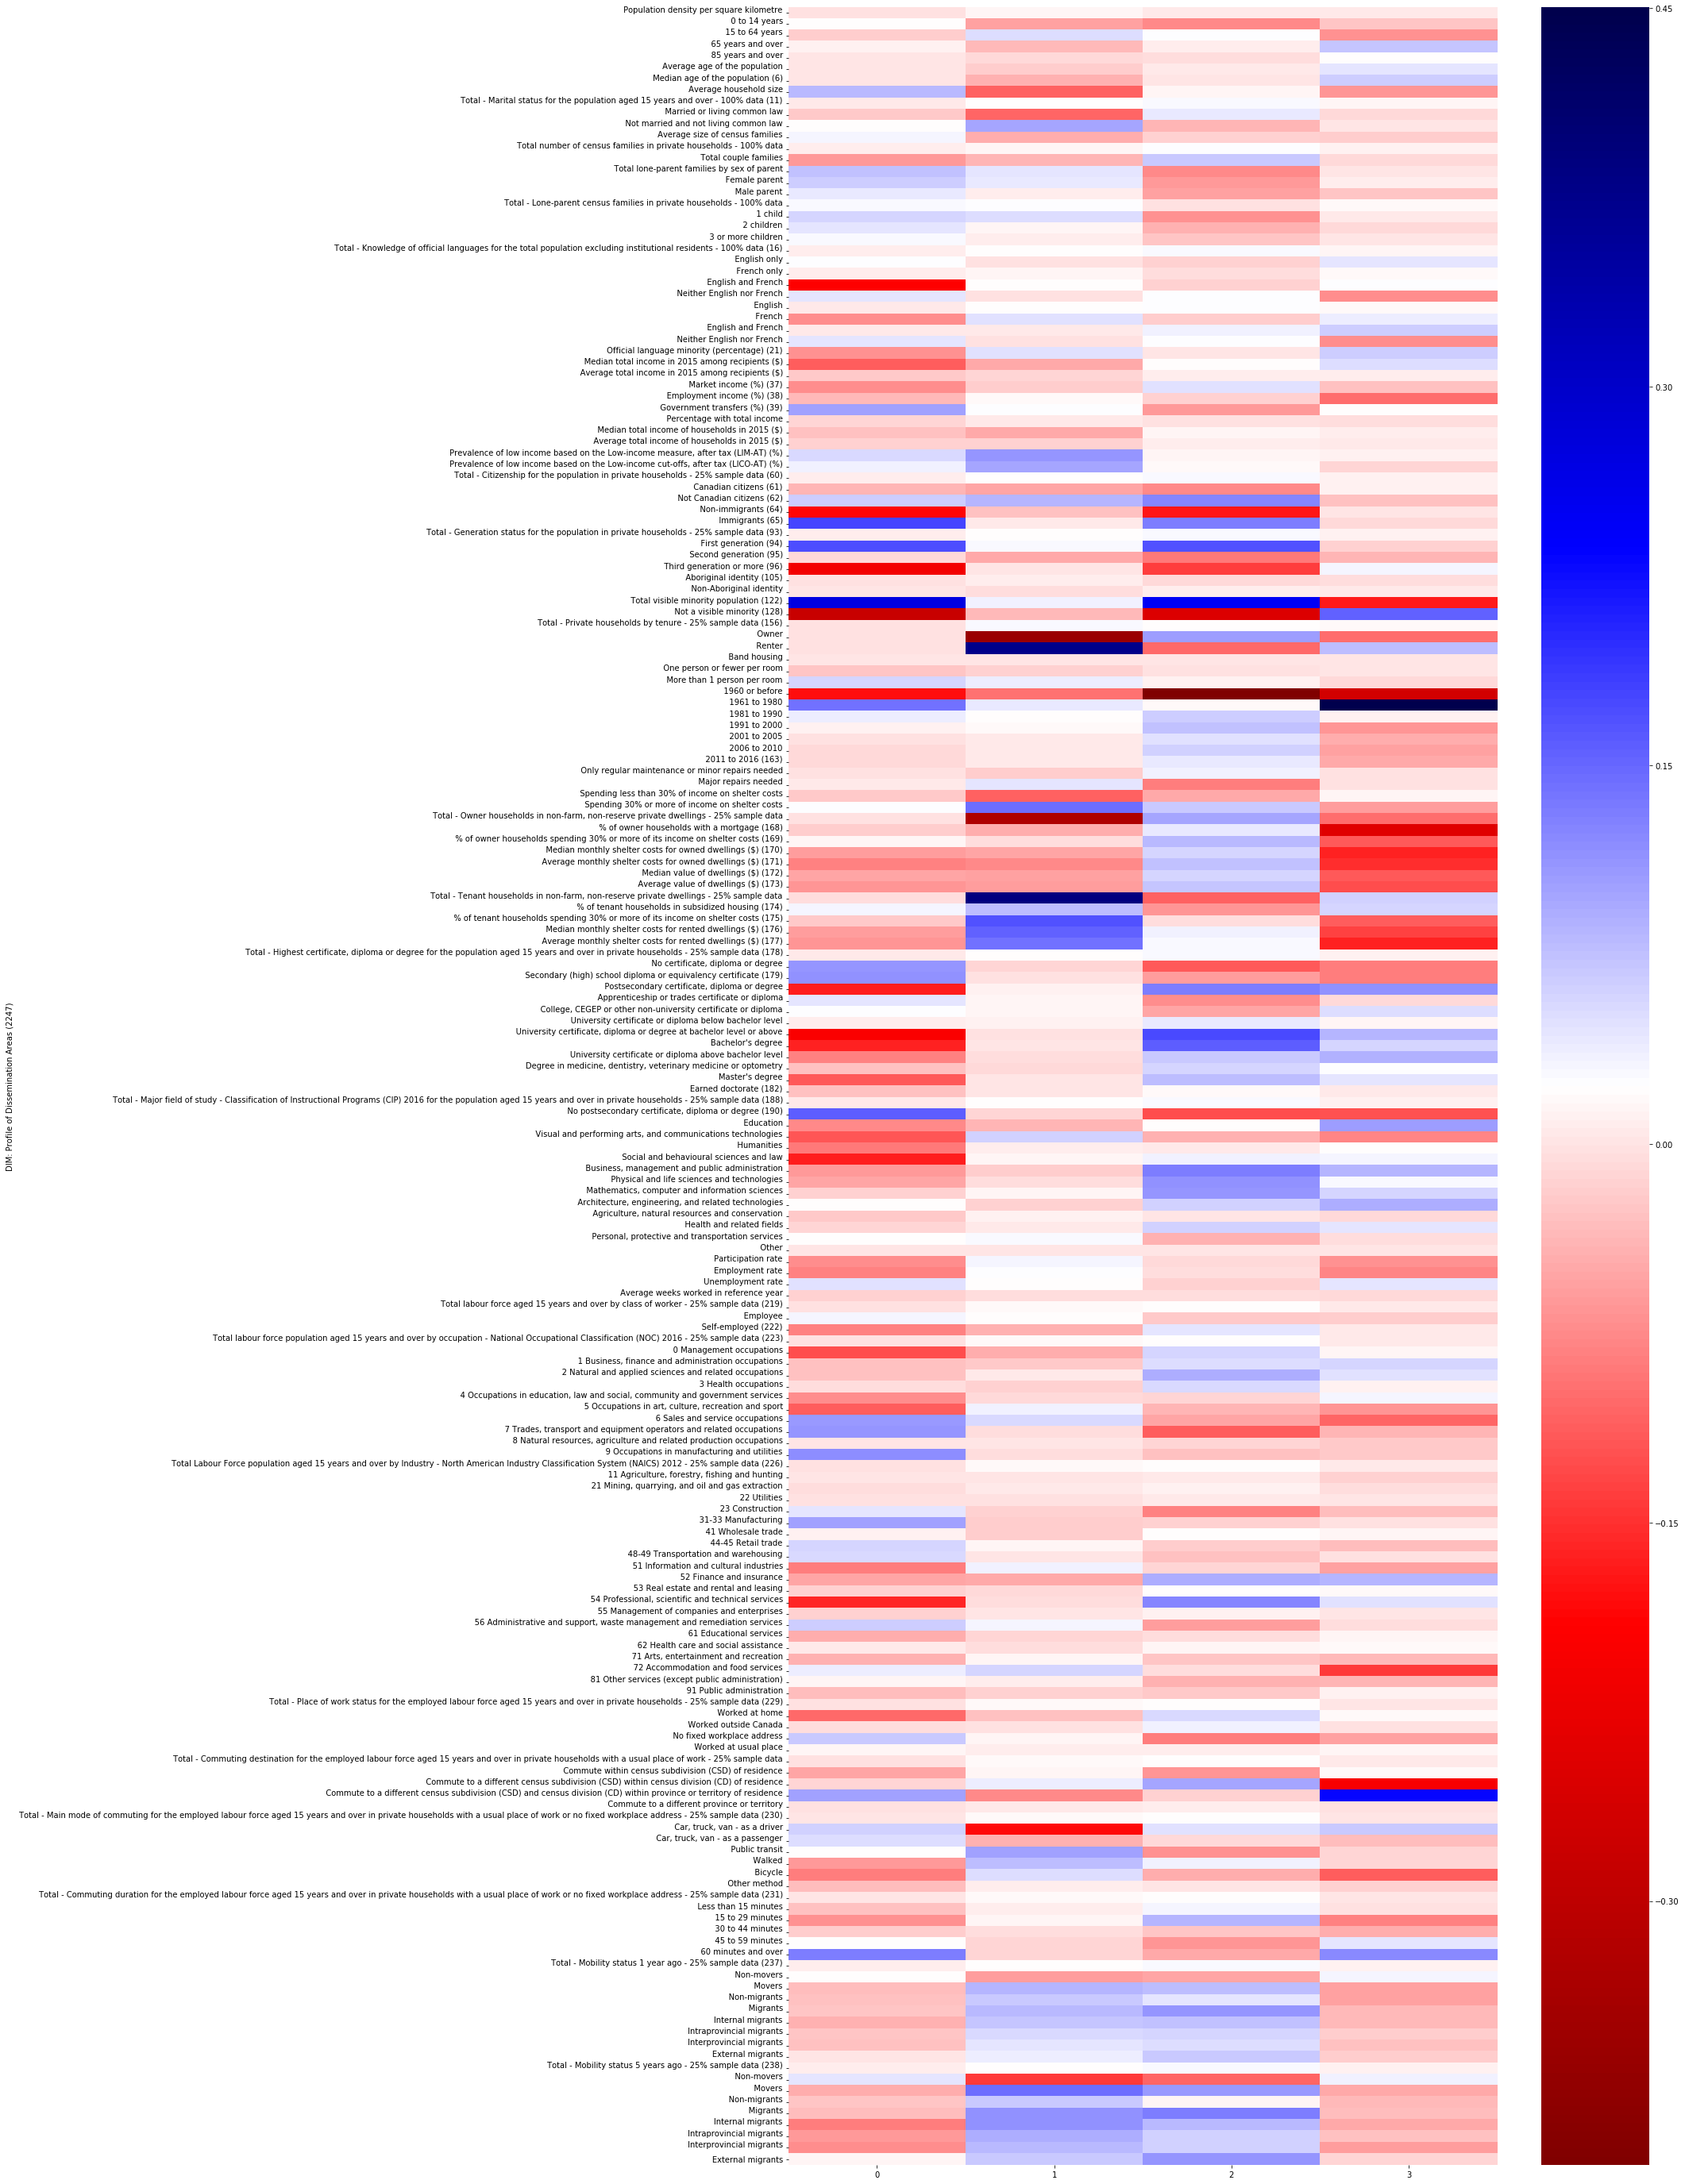

In [55]:
PCA_CPs.columns = PCA_CPs.columns.astype(str)
#plot heatmap of variables and components --> how were the components created?
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,50))
sns.heatmap(PCA_CPs.drop(['index'], axis=1), annot=False, cmap  = 'seismic_r');
#sns.clustermap(test_PCA_BC.drop(['index'], axis=1), annot=False, figsize=(20,50), cmap  = 'viridis');

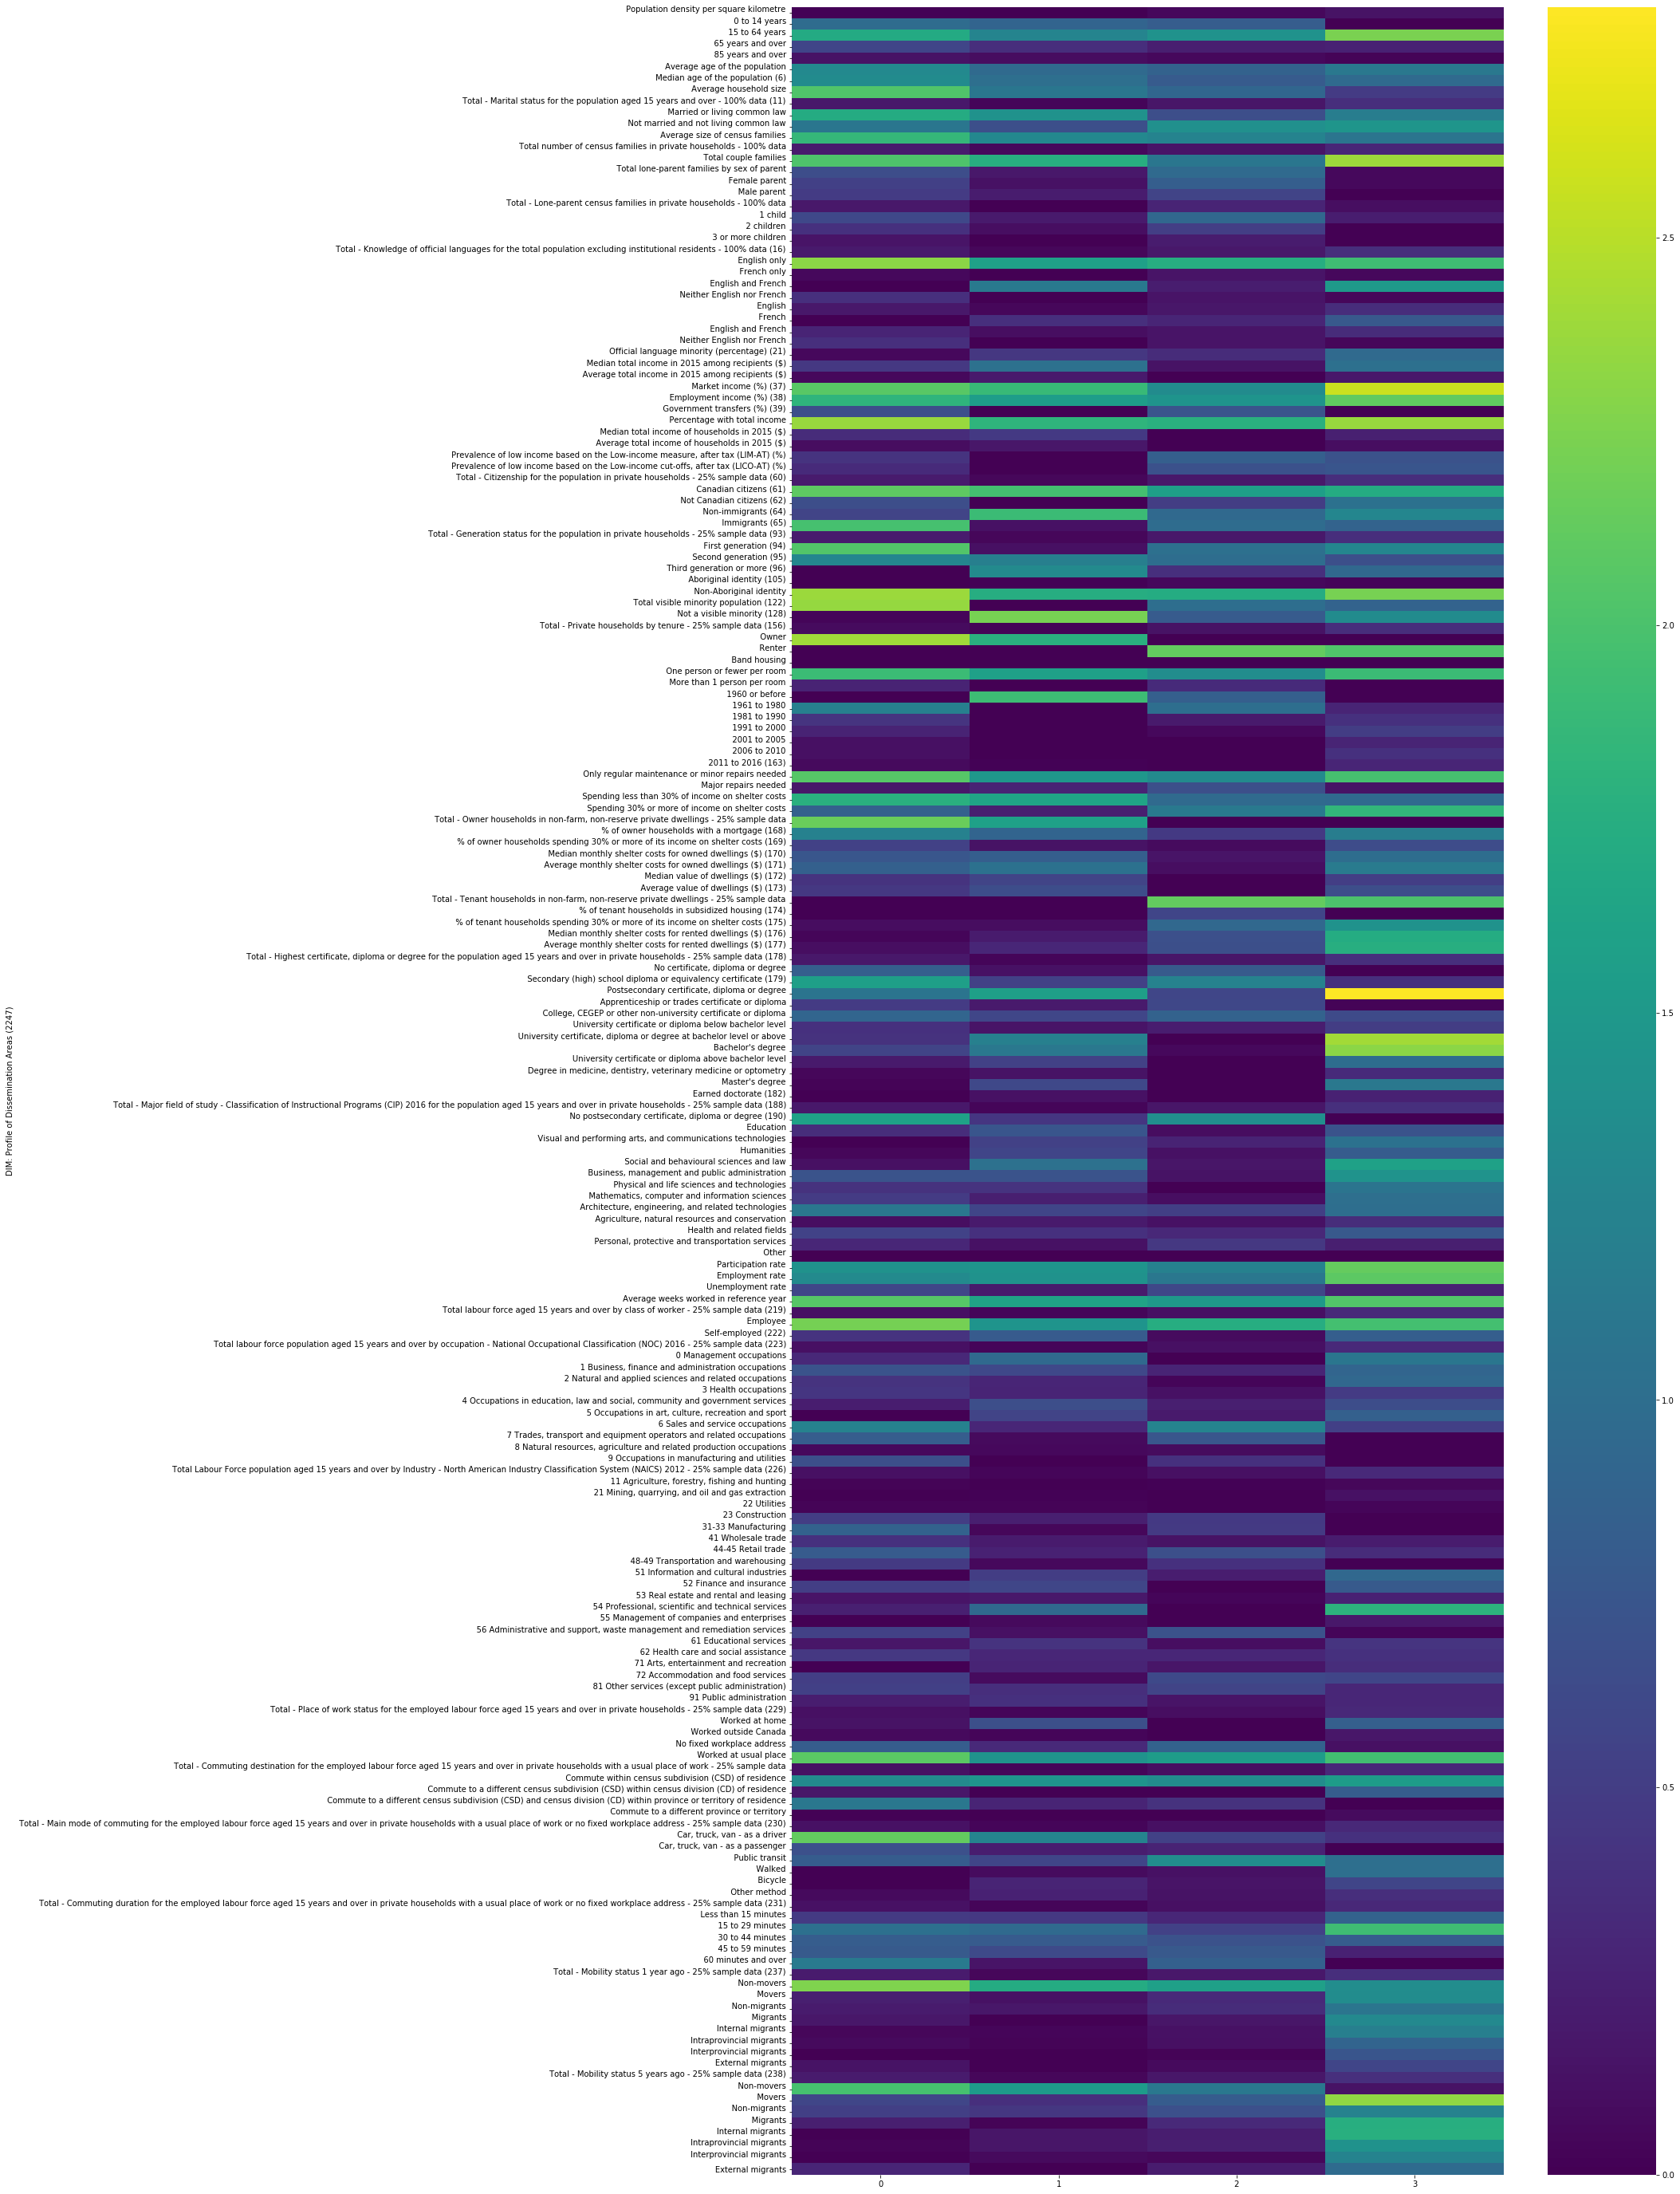

In [56]:
NMF_CPs.columns = NMF_CPs.columns.astype(str)
#plot heatmap of variables and components --> how were the components created?
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,50))
sns.heatmap(NMF_CPs.drop(['index'], axis=1), annot=False, cmap  = 'viridis');
#sns.clustermap(test_PCA_BC.drop(['index'], axis=1), annot=False, figsize=(20,50), cmap  = 'viridis');

#### In the code blocks below we plot the census variables with the lowest and highest attributes for each component

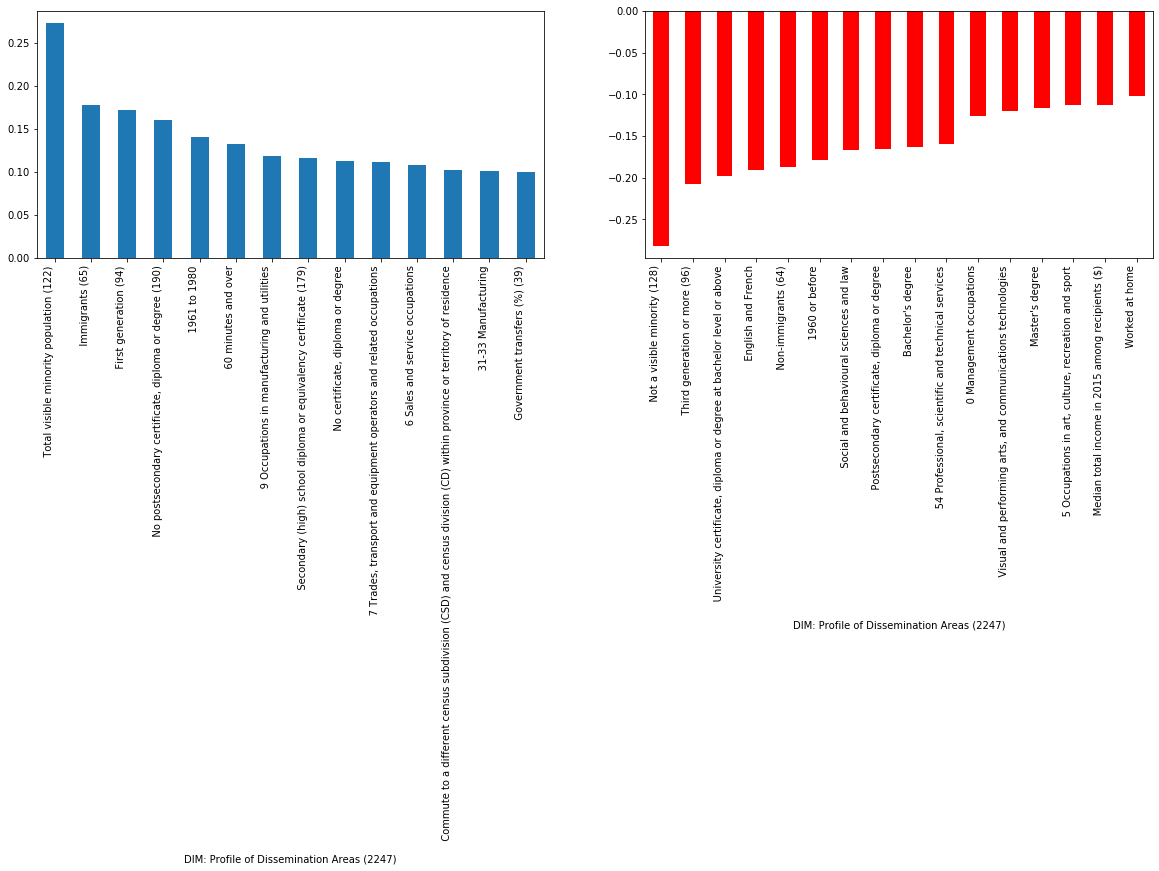

In [57]:
plt.figure(figsize=(20,10))
#group 0
plt.subplot(2,2,1)
PCA_CPs['0'][PCA_CPs['0'] > 0.1].sort_values(ascending = False).plot(kind='bar')
plt.subplot(2,2,2)
PCA_CPs['0'][PCA_CPs['0'] < -0.1].sort_values(ascending = True).plot(kind='bar', color='red')
plt.show()

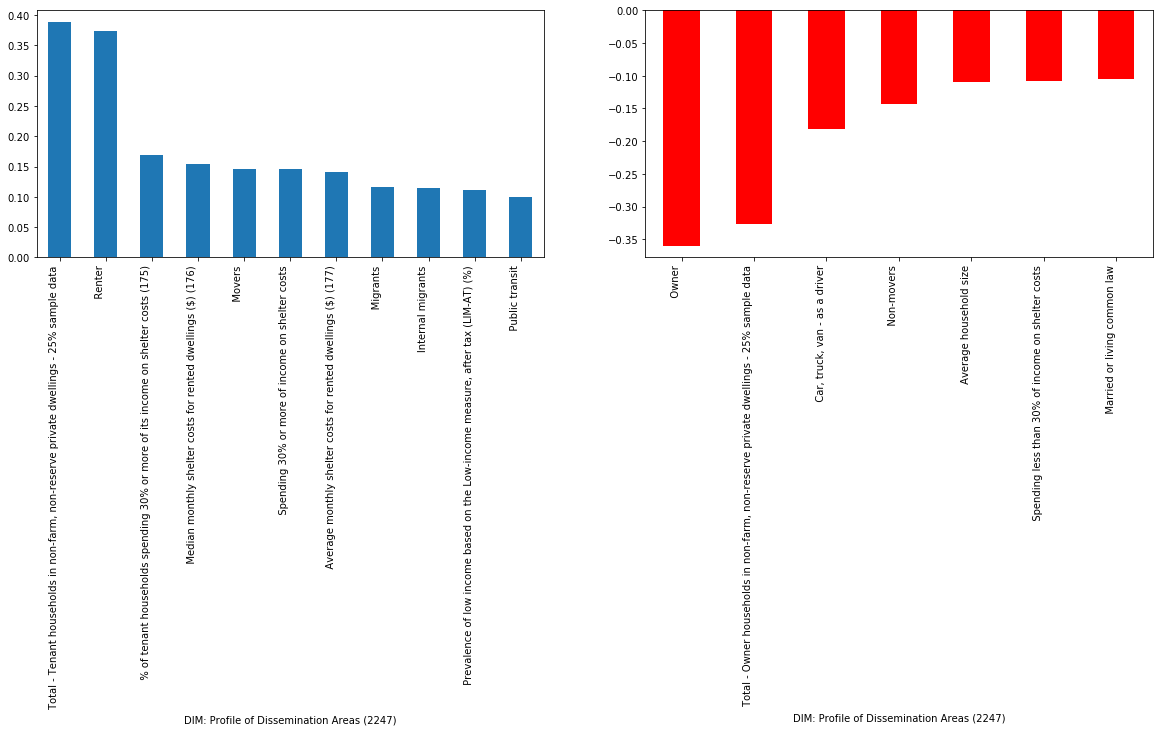

In [58]:
plt.figure(figsize=(20,10))

#group 1
plt.subplot(2,2,3)
PCA_CPs['1'][PCA_CPs['1'] > 0.1].sort_values(ascending = False).plot(kind='bar')
plt.subplot(2,2,4)
PCA_CPs['1'][PCA_CPs['1'] < -0.1].sort_values(ascending = True).plot(kind='bar', color='red')

plt.show()

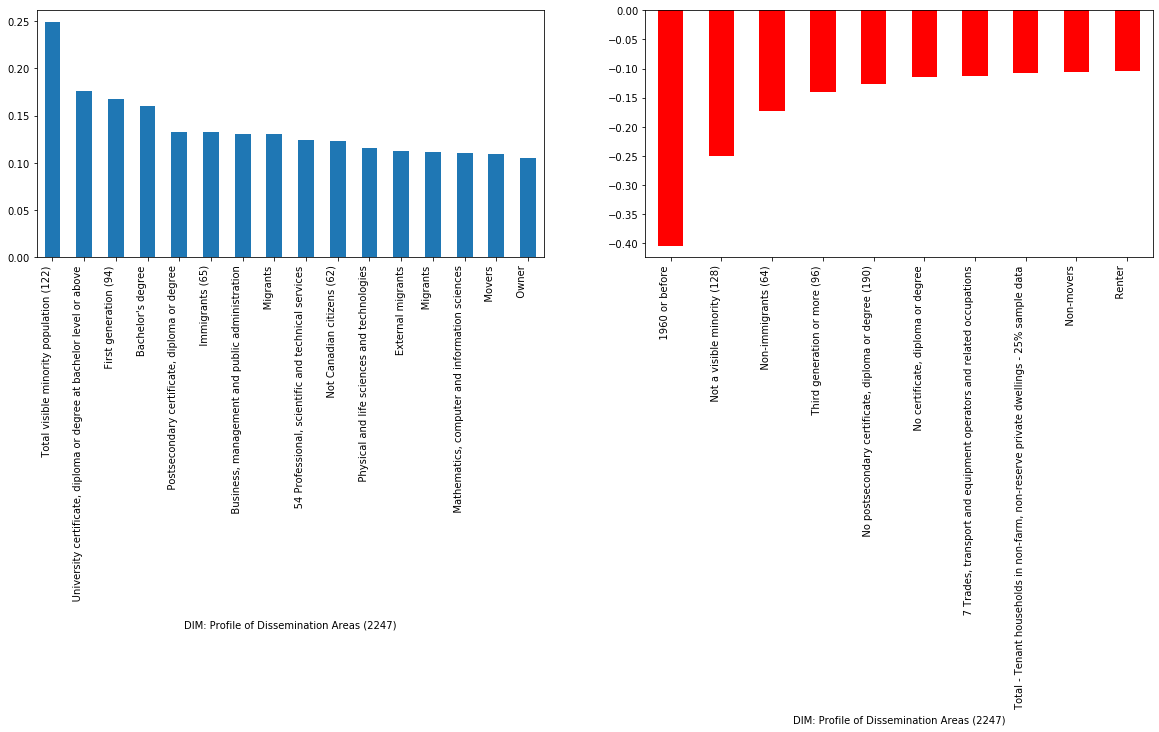

In [59]:
plt.figure(figsize=(20,10))

#group 2
plt.subplot(2,2,1)
PCA_CPs['2'][PCA_CPs['2'] > 0.1].sort_values(ascending = False).plot(kind='bar')
plt.subplot(2,2,2)
PCA_CPs['2'][PCA_CPs['2'] < -0.1].sort_values(ascending = True).plot(kind='bar', color='red')

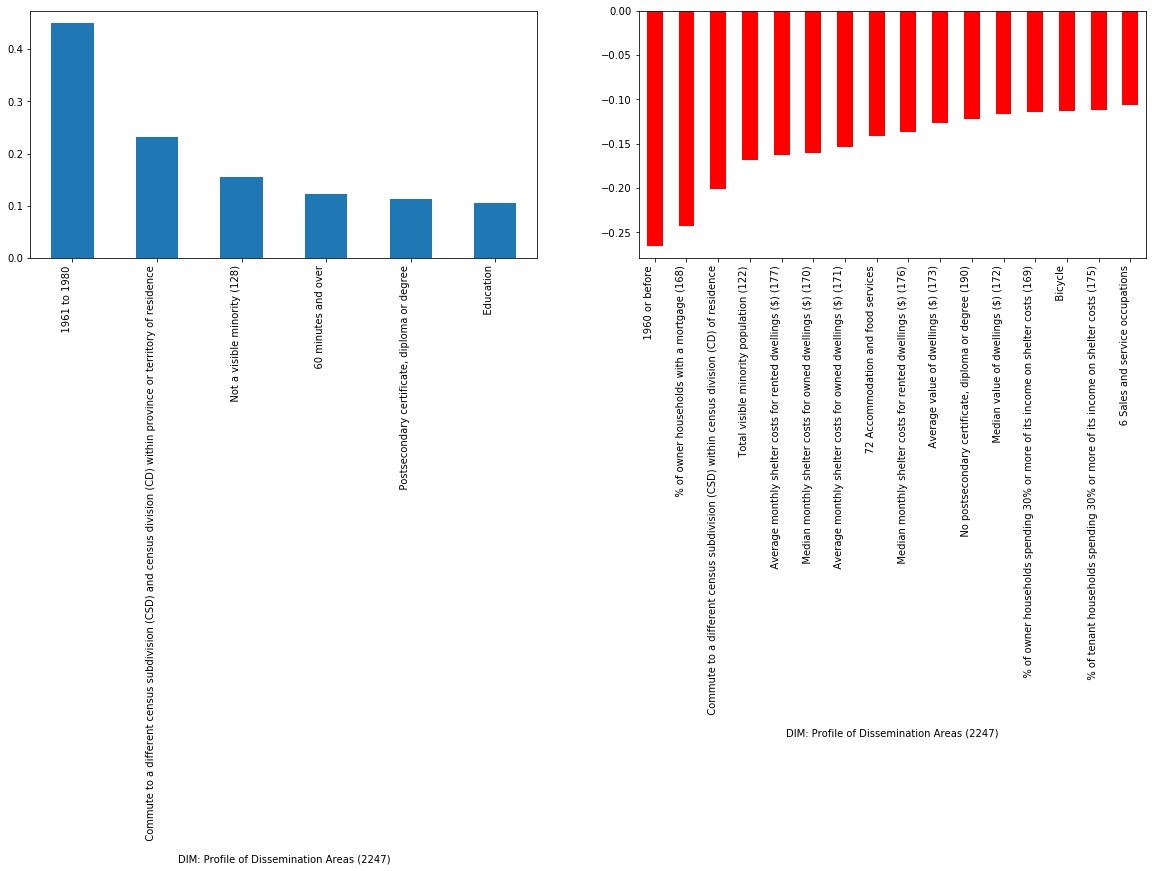

In [60]:
plt.figure(figsize=(20,10))

#group3
plt.subplot(2,2,3)
PCA_CPs['3'][PCA_CPs['3'] > 0.1].sort_values(ascending = False).plot(kind='bar')
plt.subplot(2,2,4)
PCA_CPs['3'][PCA_CPs['3'] < -0.1].sort_values(ascending = True).plot(kind='bar', color='red')

plt.show()

KeyError: '4'

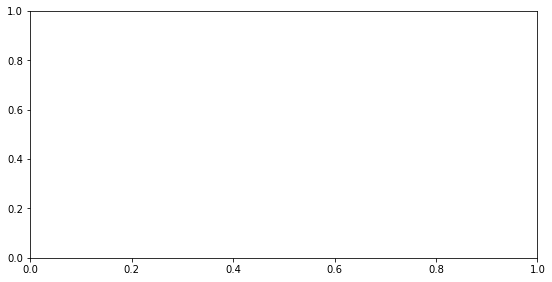

In [61]:
plt.figure(figsize=(20,10))

#group4
plt.subplot(2,2,1)
PCA_CPs['4'][PCA_CPs['4'] > 0.05].sort_values(ascending = False).plot(kind='bar')
plt.subplot(2,2,2)
PCA_CPs['4'][PCA_CPs['4'] < -0.1].sort_values(ascending = True).plot(kind='bar', color='red')

plt.show()

In [252]:
f = open('analysis_results/PCA/MV12PCA_groups.txt', 'w')
for i in range(0, 12):
    f.write("group_" + str(i) + "\n" + str(test_PCA_BC[str(i)][test_PCA_BC[str(i)] > 0.1].sort_values(ascending=False)) + "\n" + 
            str(test_PCA_BC[str(i)][test_PCA_BC[str(i)] < -0.1].sort_values(ascending=True)) + "\n")